# Topic -  Predictive Modeling and Forecasting of CDS using Machine Learning and Time Series Analysis

### Summary - This project involves the application of machine learning regression models and time series forecasting to predict the Credit Default Swap (CDS) spread. RandomForestRegressor and XGBRegressor were used for prediction, while Prophet was employed for time series forecasting of the features. The predictions were visualized, and an interactive forecasting tool was created for user-defined future predictions.


# Data import, cleanse, Normalized and scaled, pre processed based on features

In [115]:
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Define the date range
start_date = datetime.datetime(1980, 1, 1)
end_date = datetime.datetime(2023, 12, 31)

# Define the FRED symbols for the indicators
indicators = {
    'GDP': 'GDP',
    'CPIAUCSL': 'Inflation',
    'UNRATE': 'Unemployment',
    'GFDEBTN': 'Public Debt',
    'NETFI': 'Net Foreign Assets',
    'TCMDO': 'Domestic Debt',
    'FPCPITOTLZGUSA': 'Inflation',
    'EXUSUK': 'Exchange Rate',
    'GPDIC1': 'Investment',
    'BOPGSTB': 'Balance of Payments',
    'CP': 'Corporate Profits',
}

# Fetch the data and resample to quarterly frequency
dfs_macro = {}
for symbol, indicator in indicators.items():
    df = pdr.get_data_fred(symbol, start_date, end_date)
    df = df.resample('Q').mean()
    df = df.interpolate(method='time')
    dfs_macro[indicator] = df

# Import CDS data
cds_data = pd.read_csv('CDS.csv', parse_dates=['Date'], dayfirst=True)
cds_data.set_index('Date', inplace=True)
cds_data.sort_index(inplace=True)
cds_data = cds_data[['Price']]
cds_data.columns = ['CDS']

# Resample CDS data to quarterly frequency
cds_data = cds_data.resample('Q').last()

# Combine all data into a single DataFrame
data = pd.concat([cds_data] + list(dfs_macro.values()), axis=1)

# Drop rows with missing values
data.dropna(inplace=True)







# Final Datasets ready with addtional features (VIX, oil, global vix, sentiment*, Yield)
existing_data = data

# datasets are loaded into pandas dataframes: oil_df, t10_yeild_df, vix_df, ice_global_df

oil_df = pd.read_excel("oil_data.xlsx")
t10_yeild_df = pd.read_csv("T10Y2Y_yeild.csv")
vix_df = pd.read_csv("VIX_History.csv")
ice_global_df = pd.read_csv("ICE_Golbal_VOL.csv")

# Convert dates to datetime format and set them as index
oil_df['Date'] = pd.to_datetime(oil_df['Date'])
t10_yeild_df['DATE'] = pd.to_datetime(t10_yeild_df['DATE'])
vix_df['Date'] = pd.to_datetime(vix_df['Date'])
ice_global_df['Date'] = pd.to_datetime(ice_global_df['Date'])

oil_df.set_index('Date', inplace=True)
t10_yeild_df.set_index('DATE', inplace=True)
vix_df.set_index('Date', inplace=True)
ice_global_df.set_index('Date', inplace=True)

# Resample to quarterly frequency, starting in January, and taking last observation of the quarter
oil_df = oil_df.resample('Q').last()
t10_yeild_df = t10_yeild_df.resample('Q').last()
vix_df = vix_df.resample('Q').last()
ice_global_df = ice_global_df.resample('Q').last()

# Rename columns accordingly
oil_df.rename(columns={"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)": "oil_price"}, inplace=True)
t10_yeild_df.rename(columns={"T10Y2Y": "T10yeild"}, inplace=True)
vix_df.rename(columns={"Price": "VIX"}, inplace=True)
ice_global_df.rename(columns={"Price": "Global VIX ICE"}, inplace=True)

# existing_data's index is already in datetime format, now let's join the datasets

merged_df = existing_data.join(oil_df[['oil_price']], how='left')
merged_df = merged_df.join(t10_yeild_df[['T10yeild']], how='left')
merged_df = merged_df.join(vix_df[['VIX']], how='left')
merged_df = merged_df.join(ice_global_df[['Global VIX ICE']], how='left')



# Adding Sentiment Analysis

# Convert sentiment dates to datetime format and set as index
sentiment_df = pd.read_excel("Senti.xlsx")
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df.set_index('Date', inplace=True)

# Resample sentiment data to quarterly frequency, taking last observation of the quarter
sentiment_df = sentiment_df.resample('Q').last()

# Rename columns accordingly
sentiment_df.rename(columns={"Sentiment Score": "Sentiment"}, inplace=True)

# Join sentiment_df to the existing DataFrame
merged_df = merged_df.join(sentiment_df[['Sentiment']], how='left')

# Fill NaN sentiment values with the interpolation
merged_df['Sentiment'] = merged_df['Sentiment'].interpolate(method='linear')






#Data preprocessing for yeild missing and dirty values

# Replace dots with NaN
merged_df['T10yeild'] = merged_df['T10yeild'].replace('.', np.nan)

# Convert the column to float
merged_df['T10yeild'] = merged_df['T10yeild'].astype(float)

# Fill NaN values with the mean of the surrounding values
merged_df['T10yeild'] = merged_df['T10yeild'].interpolate(method='linear') # filling values based on the feature logic


data = merged_df

# Create a new feature - Debt to GDP ratio
data['Debt_to_GDP'] = data['GFDEBTN'] / data['GDP'] # Feature engineering 1

# Creating a new column called Coverage Ratio
data['Coverage_Ratio'] = data['CP'] / data['GFDEBTN'] # feature engineering 2
 

# Trial of PCA explanation - Why it peforms better ? and what can go wrong ?

Loss of Important Information: While PCA tries to preserve as much information as possible in the principal components, some information is still lost during the process. Especially in the case where PCA is used to significantly reduce dimensionality, it's possible that some of the original variables which were predictive of the outcome were not well-represented in the principal components.

PCA is Unsupervised: PCA is an unsupervised technique, meaning that it doesn't take into account the target variable when determining the principal components. This means that, while the principal components explain a lot of the variance in the predictors, they might not necessarily be good predictors of the target variable. In contrast, the original variables may have a direct relationship with the target variable, which is lost after PCA.

Complex Interactions Between Variables: Some machine learning models, like XGBoost and RandomForest, are capable of modeling complex interactions between variables. After applying PCA, these interactions may be lost or obscured, leading to worse performance.

Overfitting: Without PCA, models might be overfitting to the training data, giving higher performance metrics. But this might not generalize well to new, unseen data. PCA can help with overfitting by reducing the number of features, but at the cost of lower performance on the training data.

Absolute correlation with CDS:
 Debt_to_GDP       0.805474
Global VIX ICE    0.786426
VIX               0.786426
GFDEBTN           0.783173
CP                0.756883
GDP               0.747992
GPDIC1            0.715513
TCMDO             0.683307
EXUSUK            0.628650
T10yeild          0.496218
Coverage_Ratio    0.439557
UNRATE            0.355887
oil_price         0.332646
FPCPITOTLZGUSA    0.232781
BOPGSTB           0.125583
Sentiment         0.089583
NETFI             0.017403
dtype: float64


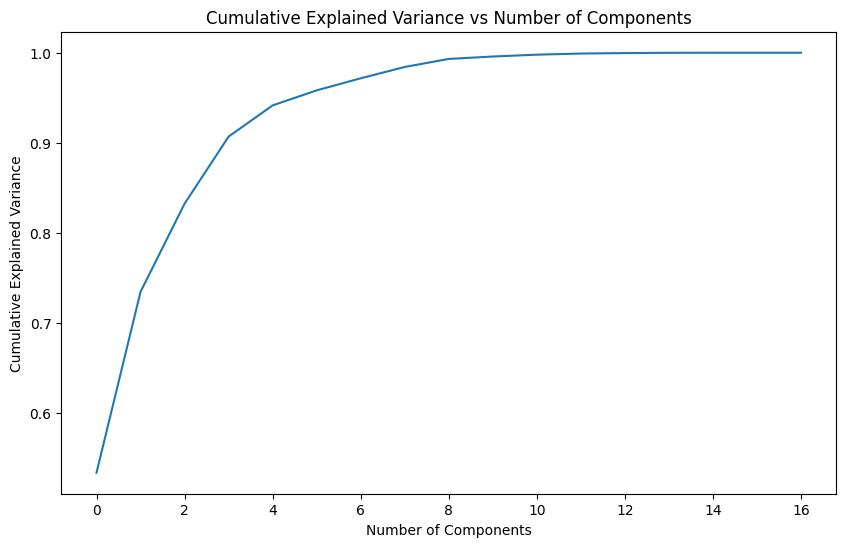

The first 5 components explain 94.15% of the variance in the original data.
R-squared for RandomForestRegressor: 0.7795649095297553
R-squared for XGBRegressor: 0.8568481568377835


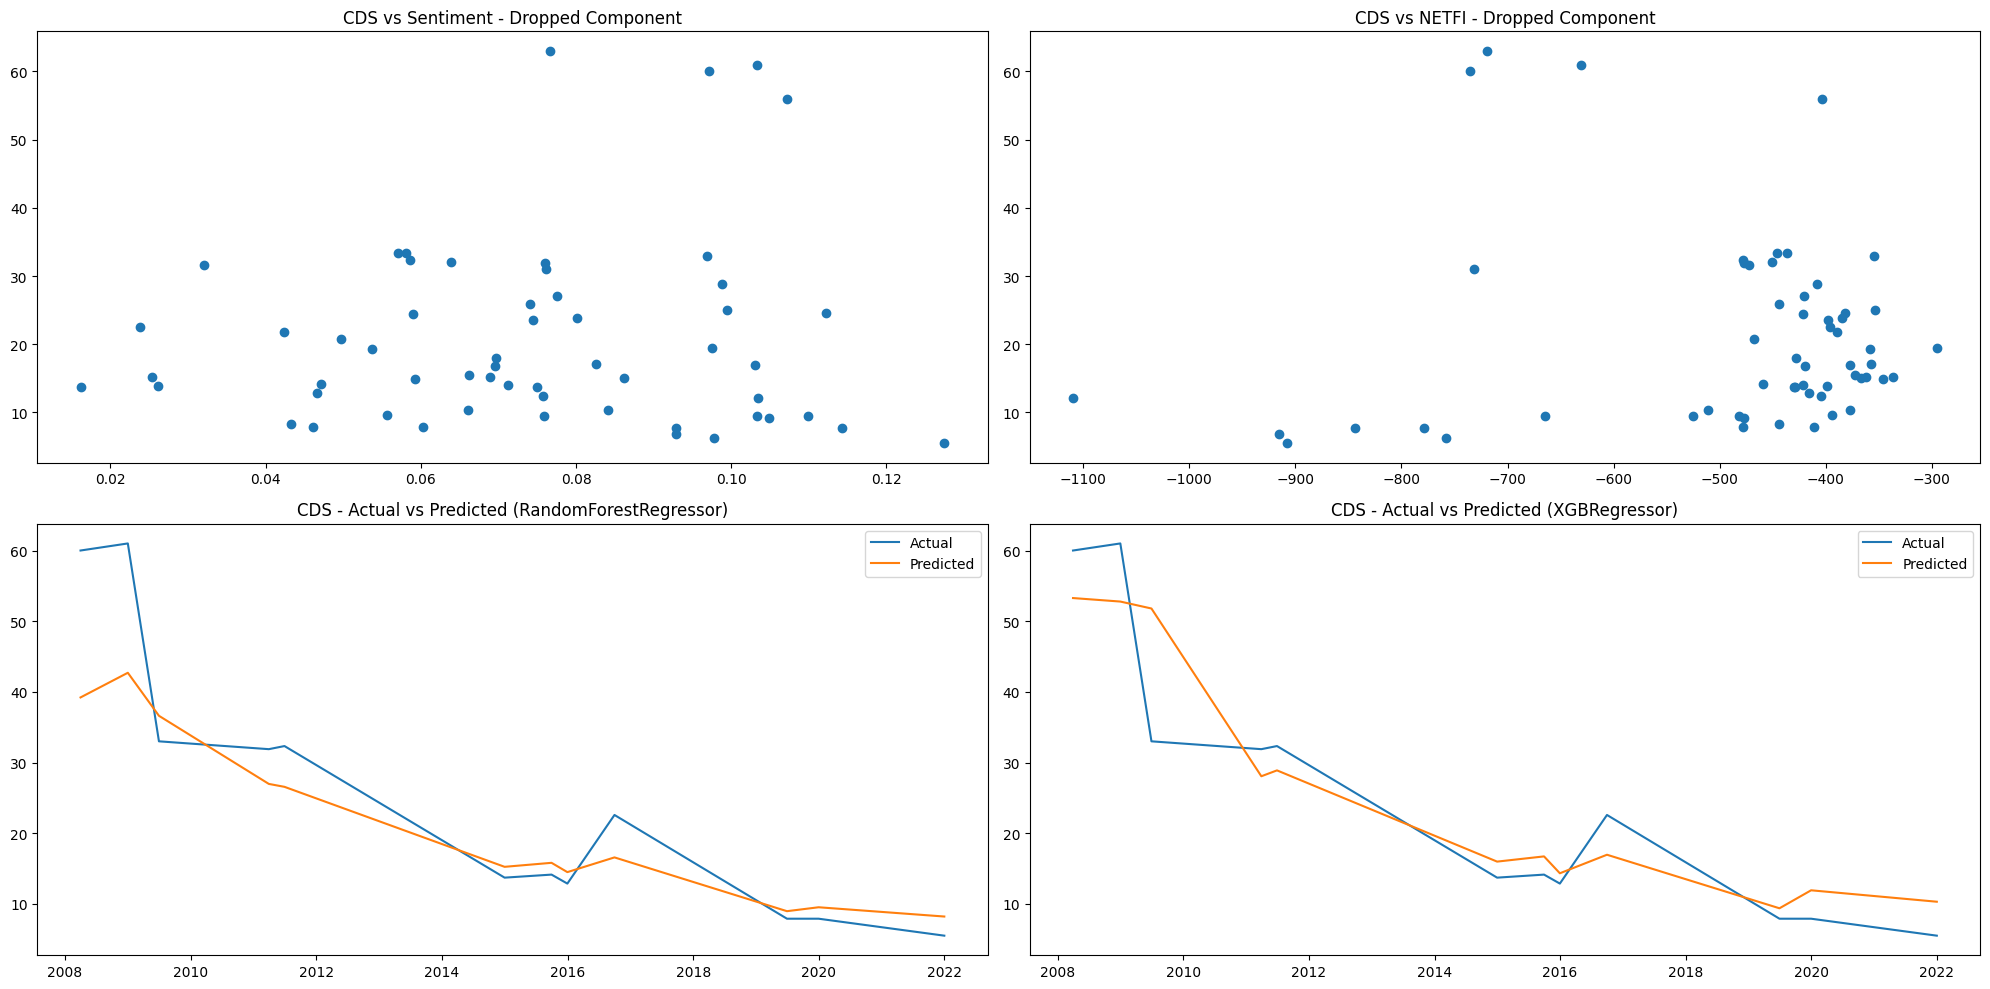

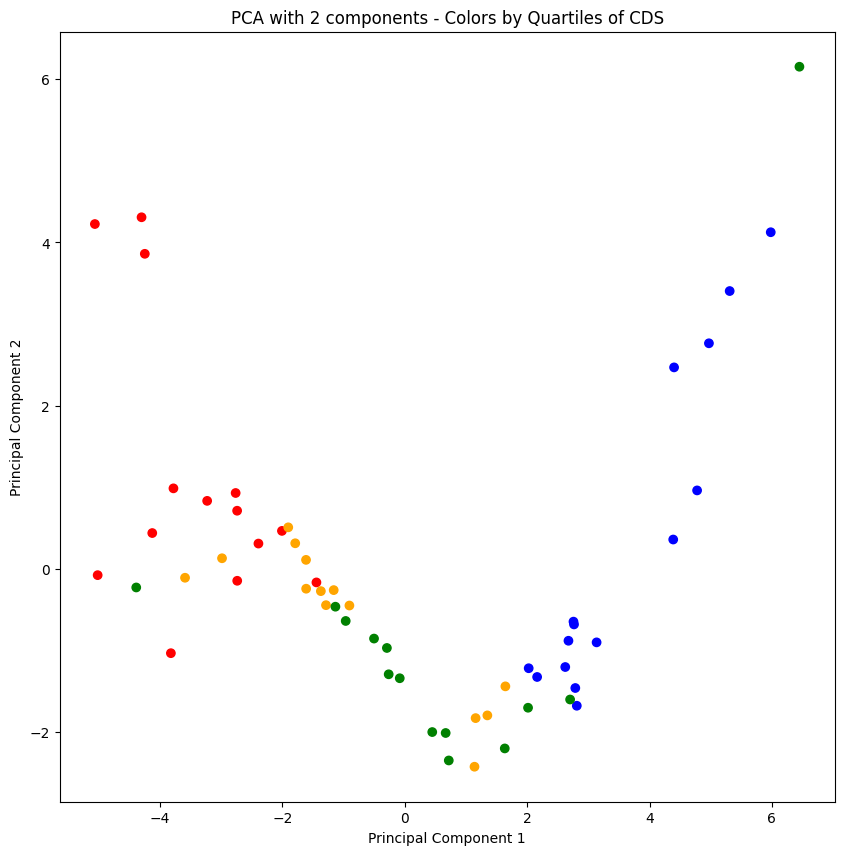

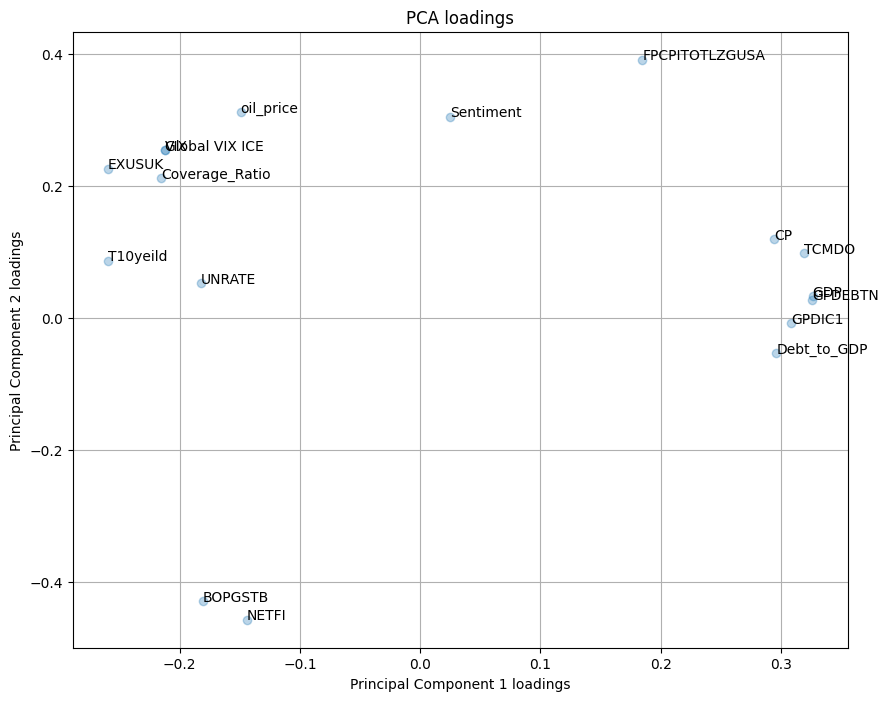

In [121]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define predictors (X) and target (y)
X = data.drop('CDS', axis=1)
y = data['CDS']

# Correlation between original features and CDS
correlation_matrix = X.corrwith(y).abs().sort_values(ascending=False)
print("Absolute correlation with CDS:\n", correlation_matrix)

# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Fitting PCA with all components
pca_all = PCA()
X_all = pca_all.fit_transform(X_scaled)

# PCA components and explained variance
#print("PCA Components:\n", pca_all.components_) # uncomment
#print("Explained variance:\n", pca_all.explained_variance_ratio_) #uncomment for data

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca_all.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.show()

# Print out the proportion of variance explained by the first few components
n_components = 5
print(f'The first {n_components} components explain {cumulative_explained_variance[n_components-1]:.2%} of the variance in the original data.')



fig, axs = plt.subplots(2, 2, figsize=(20, 10))  # Create a grid of 2x2 subplots

# Plot the components that we will drop
for i, dropped_component in enumerate(dropped_components):
    axs[0, i].scatter(X[dropped_component], y)
    axs[0, i].set_title(f"CDS vs {dropped_component} - Dropped Component")

# Initialize and fit the models
models = [RandomForestRegressor(), XGBRegressor()]
for i, model in enumerate(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate and print R-squared
    print(f'R-squared for {model.__class__.__name__}: {r2_score(y_test, y_pred)}')

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Actual': y_test,
        'Predicted': pd.Series(y_pred, index=y_test.index)
    }).sort_index()

    # Plot predicted vs actual
    axs[1, i].plot(plot_data.index, plot_data['Actual'], label='Actual')
    axs[1, i].plot(plot_data.index, plot_data['Predicted'], label='Predicted')
    axs[1, i].legend()
    axs[1, i].set_title(f'CDS - Actual vs Predicted ({model.__class__.__name__})')

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()


# Now, drop the two least correlated features and fit PCA again
X_scaled = X_scaled.drop(dropped_components, axis=1)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
  
# PCA Plot with color mapping
plt.figure(figsize=(10, 10))

# Divide 'CDS' into quartiles
quartiles = pd.qcut(y, 4, labels=False)

# Create a color map
cmap = {0: 'blue', 1: 'green', 2: 'orange', 3: 'red'}
colors = quartiles.map(cmap)

plt.scatter(X_all[:, 0], X_all[:, 1], c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with 2 components - Colors by Quartiles of CDS')
plt.show()


# Loadings are the coefficients of the linear combinations:
loadings = pd.DataFrame(pca_all.components_.T, columns=[f'PC{i+1}' for i in range(pca_all.components_.shape[0])], index=X.columns)

# Let's plot loadings for PC1 and PC2
plt.figure(figsize=(10, 8))
plt.scatter(loadings['PC1'], loadings['PC2'], alpha=0.3)
for i, feature in enumerate(loadings.index):
    plt.annotate(feature, (loadings['PC1'].iloc[i], loadings['PC2'].iloc[i]))
plt.xlabel('Principal Component 1 loadings')
plt.ylabel('Principal Component 2 loadings')
plt.title('PCA loadings')
plt.grid(True)
plt.show()




The axes of a PCA plot represent principal components, which are combinations of your original features. They don't correspond to any single original variable that you can name.


PCA transforms your original data into a new set of orthogonal variables, which are linear combinations of the original variables. Each new variable (component) is uncorrelated with the others, and they are ordered such that the first few retain most of the variation present in all of the original variables.


The color mapping section simply creates a scatter plot of the first two PCA components of your scaled data, where the colors represent quartiles of the target variable, CDS.

# Explantion of PCA and charts - 

## PCA scatter plot:

This plot shows your data points in the space of the first two principal components. Essentially, it's showing you a 'birds-eye view' of your data. The axes of this plot are the first two principal components, which are the two 'directions' in your data that explain most of the variance. Each dot in the scatter plot is a single observation in your dataset.

The color-coding represents the quartiles of your target variable, CDS. This means that you're painting each observation with a color that represents the value of CDS. This can help you see if there's any visible relationship between the 'shape' of your data (as viewed from the top) and the value of CDS.

However, what you're not seeing in this plot is what the original variables are doing. That's where the loadings plot comes in.

## PCA Loadings plot:

The PCA loadings plot helps us interpret the PCA scatter plot in terms of our original variables. Each point in this plot corresponds to one of your original features (like GDP, Unemployment, etc). The position of each point is determined by how much that feature contributes to Principal Component 1 (on the x-axis) and Principal Component 2 (on the y-axis).

Think of each principal component as a 'recipe' that combines different amounts of each original feature. The loading of each feature is like the amount of that ingredient in the recipe.

So, if a feature has a high loading on Principal Component 1, that means the 'recipe' for Principal Component 1 includes a lot of that feature. If a feature has a high loading on both Principal Component 1 and Principal Component 2, that means both 'recipes' include a lot of that feature.

In summary, the PCA scatter plot shows you how your observations relate to each other in the space of the principal components, while the loadings plot shows you how your original variables contribute to those principal components. Together, these plots can give you a good sense of the structure in your data and how your original features relate to that structure.

# With PCA - performs better - 

Principal Component Analysis (PCA) is a dimensionality reduction technique that can often improve the performance of machine learning algorithms for several reasons:

## Noise Reduction: PCA helps in removing noise from the data by capturing the maximum variance in the data using fewer features (principal components). These components often tend to contain the signal (useful information), while the remaining components tend to contain noise. This can often lead to improved performance by reducing overfitting.

## Overcoming the Curse of Dimensionality: High-dimensional data can lead to overfitting and also make the learning process extremely slow for some machine learning algorithms. By reducing the number of features, PCA can help overcome these issues, making the algorithms more efficient and potentially improving their performance.

## Uncovering Hidden Patterns: PCA can sometimes uncover hidden patterns in the data by combining features in a way that maximizes their variance. This can lead to a better understanding of the data and improved performance of machine learning algorithms. It's also worth mentioning that PCA can often make the results more interpretable by reducing the complexity of the data.

# Without PCA + Traditional 80-20 train test

Absolute correlation with CDS:
 Debt_to_GDP       0.805474
Global VIX ICE    0.786426
VIX               0.786426
GFDEBTN           0.783173
CP                0.756883
GDP               0.747992
GPDIC1            0.715513
TCMDO             0.683307
EXUSUK            0.628650
T10yeild          0.496218
Coverage_Ratio    0.439557
UNRATE            0.355887
oil_price         0.332646
FPCPITOTLZGUSA    0.232781
BOPGSTB           0.125583
Sentiment         0.089583
NETFI             0.017403
dtype: float64


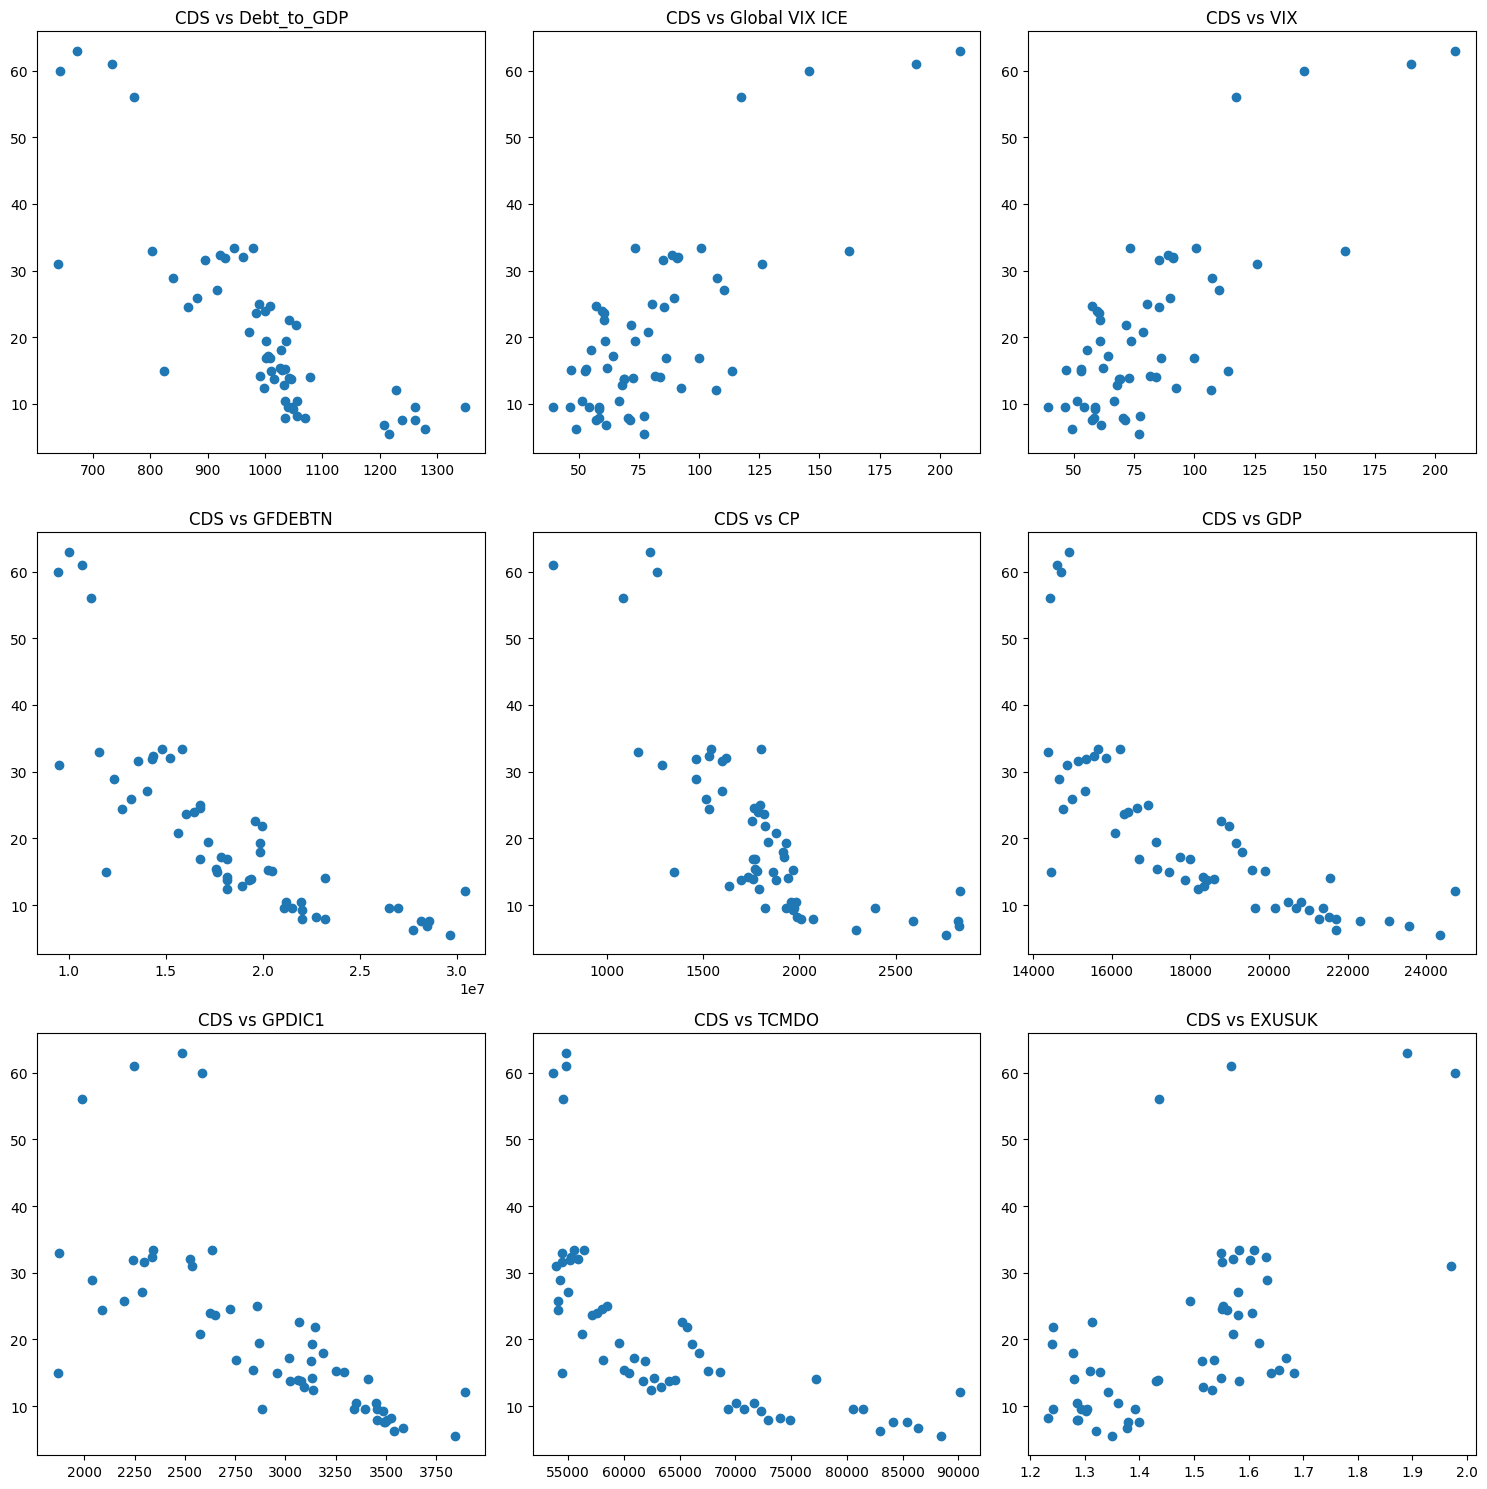

R-squared for RandomForestRegressor: 0.7456622034132683
R-squared for XGBRegressor: 0.6921114515179428


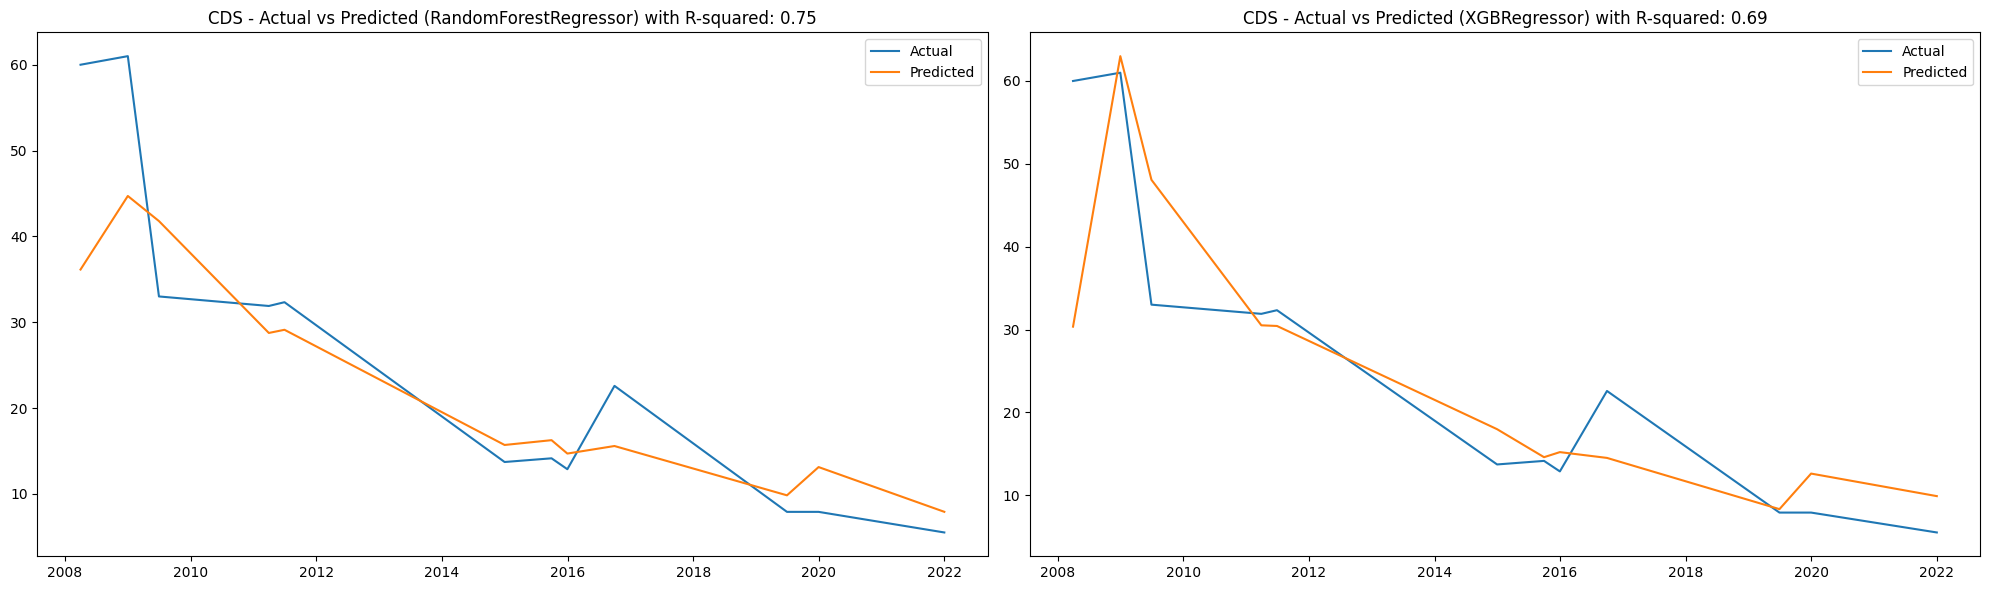

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define predictors (X) and target (y)
X = data.drop('CDS', axis=1)
y = data['CDS']

# Correlation between original features and CDS
correlation_matrix = X.corrwith(y).abs().sort_values(ascending=False)
print("Absolute correlation with CDS:\n", correlation_matrix)

# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Creating a 3x3 subplot for the 9 features with highest correlation
highest_correlated_features = correlation_matrix.index[:9]
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, feature in enumerate(highest_correlated_features):
    axs[i//3, i%3].scatter(X[feature], y)
    axs[i//3, i%3].set_title(f"CDS vs {feature}")

plt.tight_layout()
plt.show()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and fit the models
models = [RandomForestRegressor(), XGBRegressor()]

# Create subplots for predicted vs actual plots
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

for i, model in enumerate(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate and print R-squared
    r_squared = r2_score(y_test, y_pred)
    print(f'R-squared for {model.__class__.__name__}: {r_squared}')

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Actual': y_test,
        'Predicted': pd.Series(y_pred, index=y_test.index)
    }).sort_index()

    # Plot predicted vs actual
    axs[i].plot(plot_data.index, plot_data['Actual'], label='Actual')
    axs[i].plot(plot_data.index, plot_data['Predicted'], label='Predicted')
    axs[i].legend()
    axs[i].set_title(f'CDS - Actual vs Predicted ({model.__class__.__name__}) with R-squared: {r_squared:.2f}')

plt.tight_layout()
plt.show()


#  Train test using K folds to cover different cycles

Absolute correlation with CDS:
 Debt_to_GDP       0.805474
Global VIX ICE    0.786426
VIX               0.786426
GFDEBTN           0.783173
CP                0.756883
GDP               0.747992
GPDIC1            0.715513
TCMDO             0.683307
EXUSUK            0.628650
T10yeild          0.496218
Coverage_Ratio    0.439557
UNRATE            0.355887
oil_price         0.332646
FPCPITOTLZGUSA    0.232781
BOPGSTB           0.125583
Sentiment         0.089583
NETFI             0.017403
dtype: float64
R-squared for RandomForestRegressor, fold 1: 0.8086042525382717
R-squared for RandomForestRegressor, fold 2: 0.6436016068345722
R-squared for RandomForestRegressor, fold 3: 0.6914877360359868
R-squared for RandomForestRegressor, fold 4: 0.7216555667086397
R-squared for RandomForestRegressor, fold 5: 0.799856104558341
R-squared for XGBRegressor, fold 1: 0.6921114515179427
R-squared for XGBRegressor, fold 2: 0.5319809440459058
R-squared for XGBRegressor, fold 3: 0.6359763600605772
R-squared 

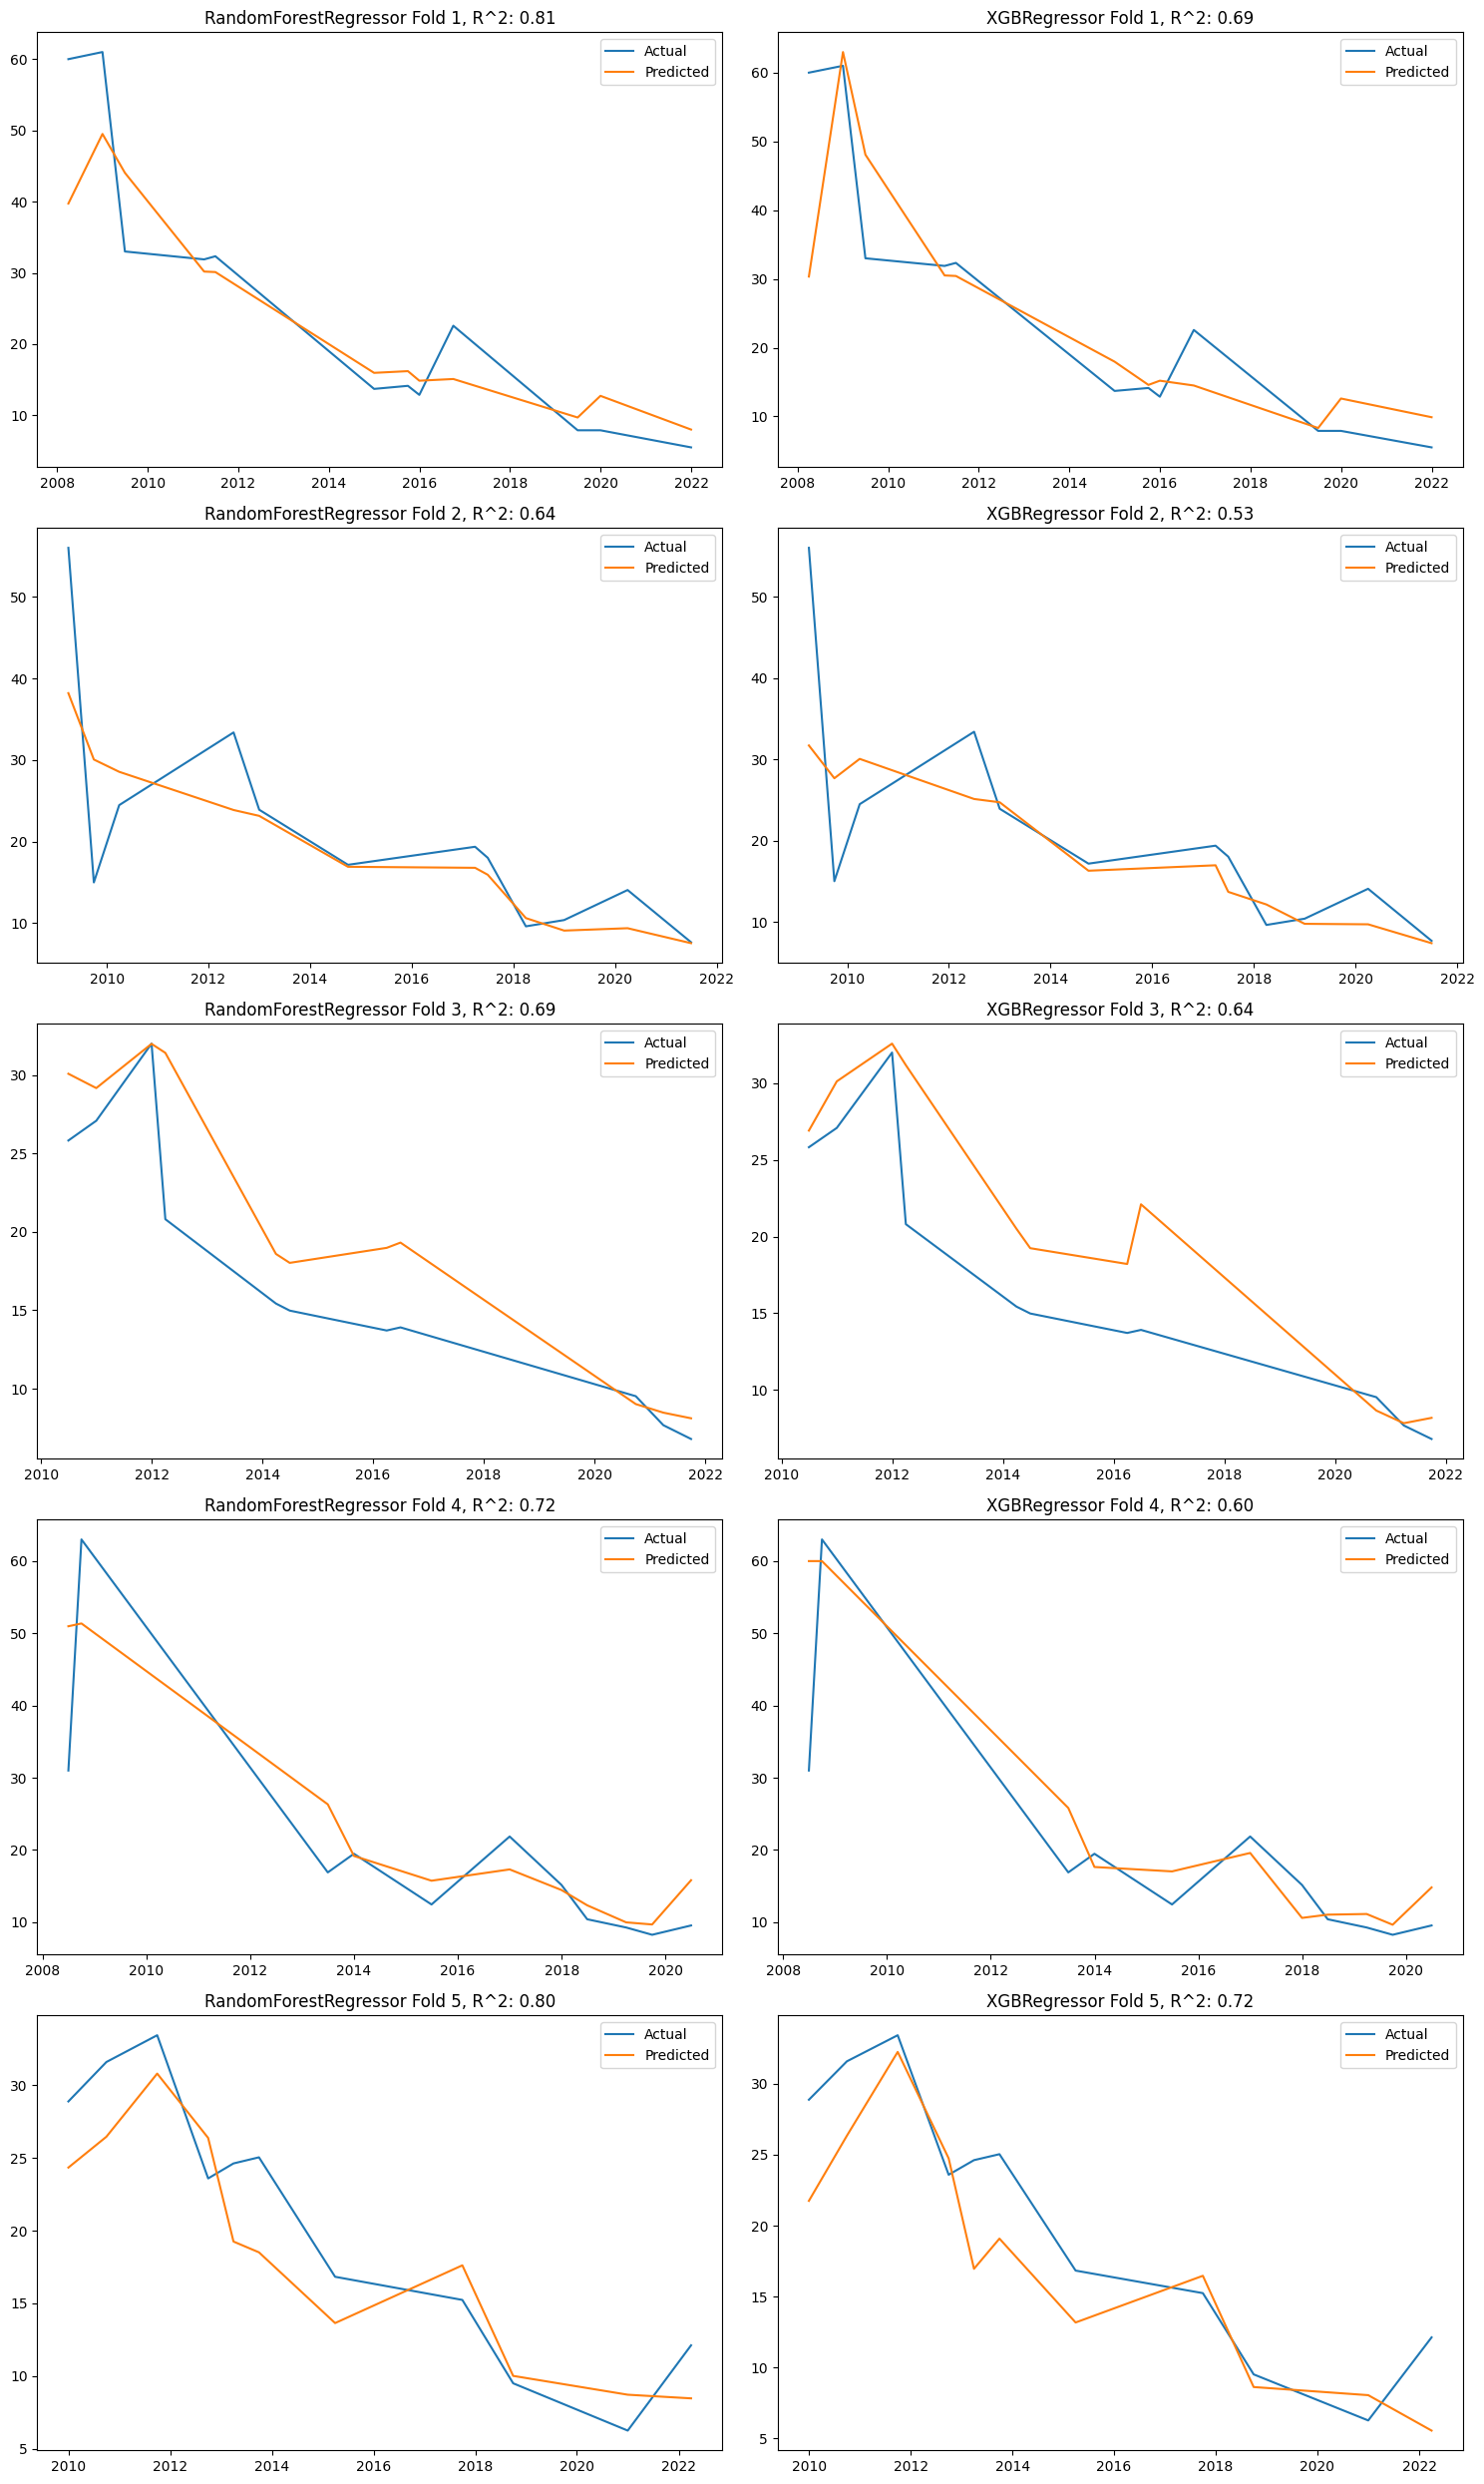

Average R-squared for RandomForestRegressor: 0.7582594125634443
Average R-squared for XGBRegressor: 0.6351446366374038


In [102]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Define predictors (X) and target (y)
X = data.drop('CDS', axis=1)
y = data['CDS']

# Correlation between original features and CDS
correlation_matrix = X.corrwith(y).abs().sort_values(ascending=False)
print("Absolute correlation with CDS:\n", correlation_matrix)

# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Initialize the models
models = [RandomForestRegressor(), XGBRegressor()]

# Define the number of folds for the cross validation (for example 5)
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)

# Create subplots outside the loop
fig, axs = plt.subplots(nrows=n_splits, ncols=len(models), figsize=(15, n_splits*5)) # Adjust size as needed

for i, model in enumerate(models):
    fold = 0
    for train_index, test_index in kf.split(X_scaled):
        # Split the data into train and test sets
        X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate and print R-squared
        r_squared = r2_score(y_test, y_pred)
        print(f'R-squared for {model.__class__.__name__}, fold {fold + 1}: {r_squared}')

        # Create a DataFrame for plotting
        plot_data = pd.DataFrame({
            'Actual': y_test,
            'Predicted': pd.Series(y_pred, index=y_test.index)
        }).sort_index()

        # Plot predicted vs actual on the corresponding subplot
        axs[fold, i].plot(plot_data.index, plot_data['Actual'], label='Actual')
        axs[fold, i].plot(plot_data.index, plot_data['Predicted'], label='Predicted')
        axs[fold, i].legend()
        axs[fold, i].set_title(f'{model.__class__.__name__} Fold {fold + 1}, R^2: {r_squared:.2f}')

        fold += 1

plt.tight_layout()
plt.show()

# If you want to get the average R-squared across all folds, you can use cross_val_score
for model in models:
    scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='r2')
    print(f'Average R-squared for {model.__class__.__name__}: {scores.mean()}')


# Forecasting features + ML (CDS) prediction on forecasted data

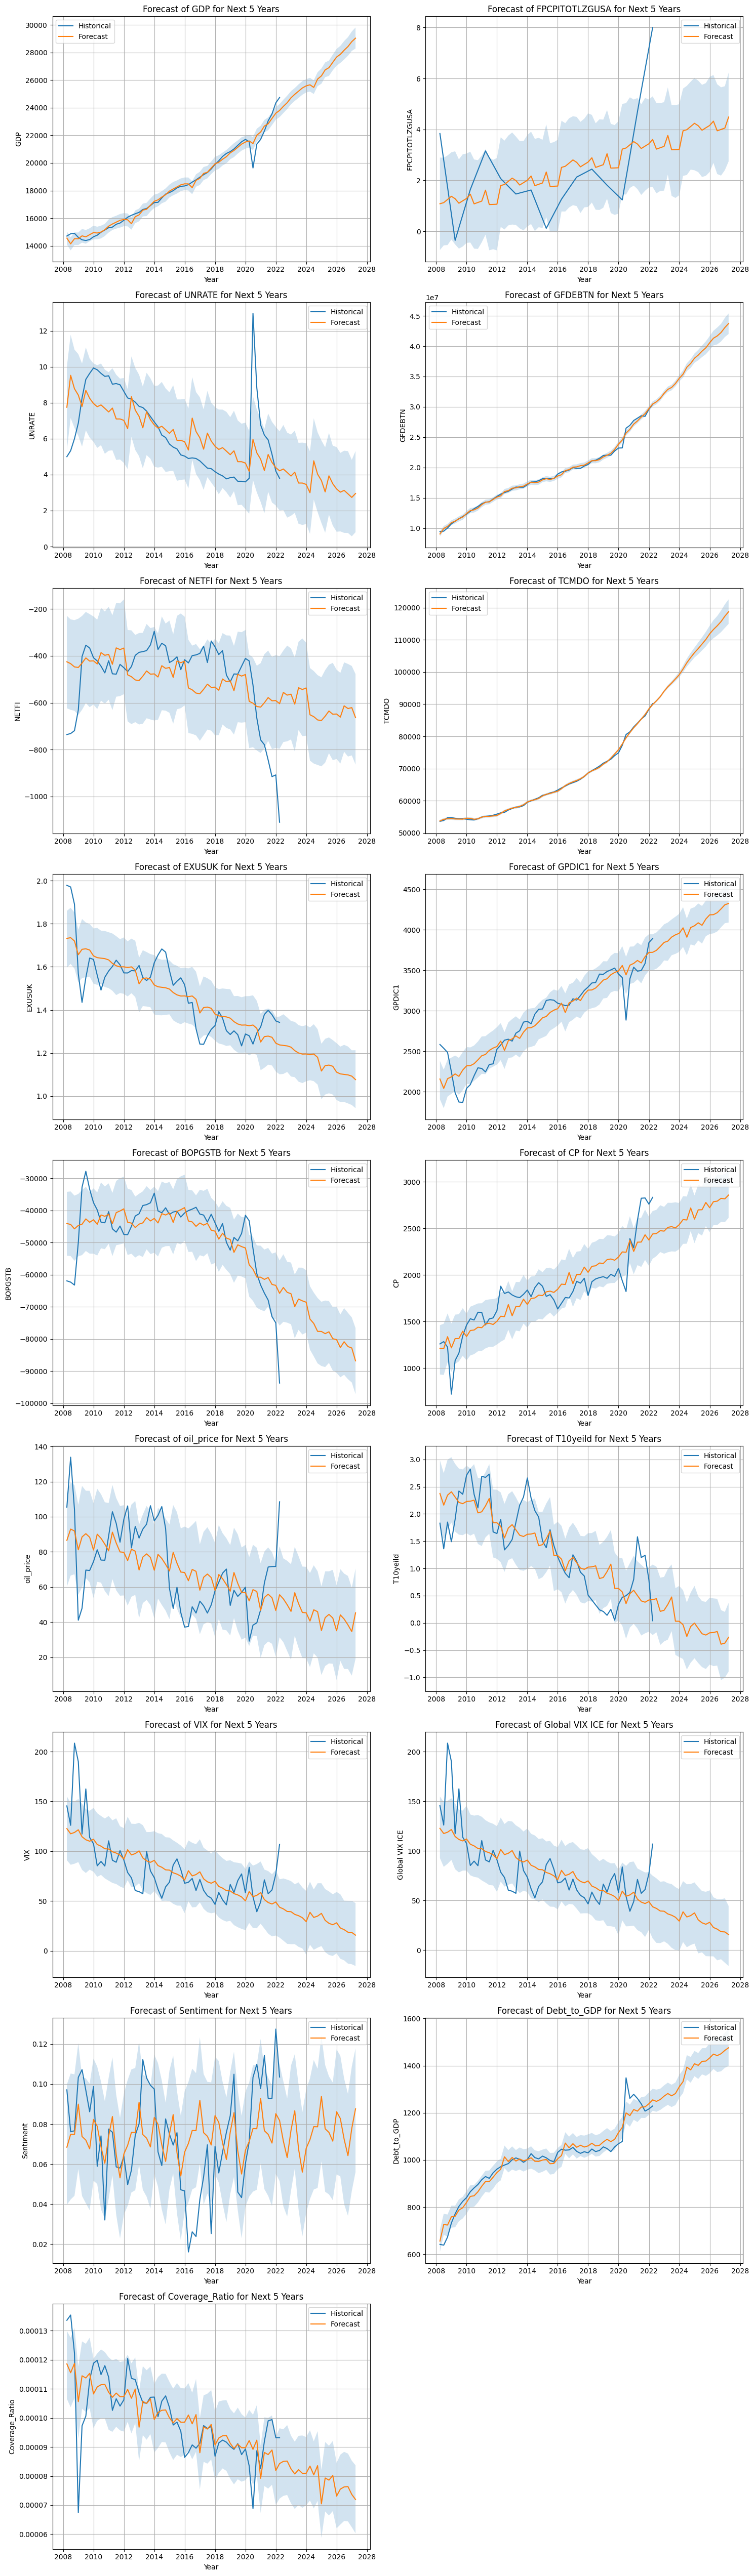

In [96]:
import matplotlib.dates as mdates
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
import logging

# Suppress INFO logs
logging.getLogger('prophet').setLevel(logging.WARNING)  # Add this line
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)  # Add this line

warnings.filterwarnings("ignore")

import plotly.graph_objs as go

# Prepare the forecasts dictionary
forecasts = {}

# Initialize the figure and axes for the 2-column subplot
fig, axs = plt.subplots(len(X.columns)//2 + len(X.columns)%2, 2, figsize=(15, 6*len(X.columns)//2))

# Forecast the features using Prophet
for i, col in enumerate(X.columns):  # using your defined X here
    df = data[[col]].reset_index().rename(columns={'index': 'ds', col: 'y'})

    # Initialize and fit the model
    model = Prophet(yearly_seasonality=True)
    model.fit(df)

    # Forecast for the next 5 years (20 quarters)
    future = model.make_future_dataframe(periods=5*4, freq='Q')
    forecast = model.predict(future)

    # Store the forecasted values
    forecasts[col] = forecast['yhat'].values[-5*4:]

    # Add the forecast plot to the subplot
    axs[i//2, i%2].plot(df['ds'], df['y'], label='Historical')
    axs[i//2, i%2].plot(future['ds'], forecast['yhat'], label='Forecast')
    axs[i//2, i%2].fill_between(future['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
    axs[i//2, i%2].set_title(f'Forecast of {col} for Next 5 Years')
    axs[i//2, i%2].set_xlabel('Year')
    axs[i//2, i%2].set_ylabel(col)
    axs[i//2, i%2].legend()
    axs[i//2, i%2].grid(True)

# Hide extra subplot axes if the number of plots is odd
if len(X.columns)%2:
    fig.delaxes(axs[-1, -1])

plt.tight_layout()
plt.show()

# Combine all forecasts into a single DataFrame and standardize it
forecasts_df = pd.DataFrame(forecasts, index=future['ds'].values[-5*4:])
forecasts_df_scaled = scaler.transform(forecasts_df)  # standardize the forecasts

# Predict the CDS for the next five years
cds_predictions = {}
for model in models:  # using your trained models here
    cds_predictions[model.__class__.__name__] = model.predict(forecasts_df_scaled)  # use scaled forecasts for prediction

# Plot the predicted CDS using Plotly for interactivity
for model_name, predictions in cds_predictions.items():
    trace = go.Scatter(
        x = forecasts_df.index,
        y = predictions,
        mode = 'lines',
        name = 'Predicted'
    )

    layout = go.Layout(
        title = f'Predicted CDS - Next 5 Years ({model_name})',
        xaxis = dict(title = 'Date'),
        yaxis = dict(title = 'CDS')
    )

    fig = go.Figure(data=[trace], layout=layout)
    fig.show()


# Live Visuals

In [108]:
from ipywidgets import interact, IntSlider, Dropdown

def plot_predictions(periods, freq):
    # Forecast the features using Prophet
    forecasts = {}
    for col in X.columns:
        df = data[[col]].reset_index().rename(columns={'index': 'ds', col: 'y'})

        # Initialize and fit the model
        model = Prophet(yearly_seasonality=True)
        model.fit(df)

        # Forecast for the next n periods with specified frequency
        future = model.make_future_dataframe(periods=periods, freq=freq)
        forecast = model.predict(future)

        # Store the forecasted values
        forecasts[col] = forecast['yhat'].values[-periods:]
        
    # Combine all forecasts into a single DataFrame and standardize it
    forecasts_df = pd.DataFrame(forecasts, index=future['ds'].values[-periods:])
    forecasts_df_scaled = scaler.transform(forecasts_df)  # standardize the forecasts

    # Predict the CDS for the next periods
    cds_predictions = {}
    for model in models:  # using your trained models here
        cds_predictions[model.__class__.__name__] = model.predict(forecasts_df_scaled)  # use scaled forecasts for prediction

    # Plot the predicted CDS using Plotly for interactivity
    for model_name, predictions in cds_predictions.items():
        trace = go.Scatter(
            x = forecasts_df.index,
            y = predictions,
            mode = 'lines',
            name = 'Predicted'
        )

        layout = go.Layout(
            title = f'Predicted CDS - Next {periods} {freq} ({model_name})',
            xaxis = dict(title = 'Date'),
            yaxis = dict(title = 'CDS')
        )

        fig = go.Figure(data=[trace], layout=layout)
        fig.show()

# Create widgets for interaction
periods_slider = IntSlider(min=1, max=50, step=1, value=20, description='Periods:')
freq_dropdown = Dropdown(options=['D', 'W', 'M', 'Q', 'Y'], value='Q', description='Frequency:')

# Use the interact function to create the interaction between the widgets and the function
interact(plot_predictions, periods=periods_slider, freq=freq_dropdown);


interactive(children=(IntSlider(value=20, description='Periods:', max=50, min=1), Dropdown(description='Freque…

In [ ]:
# USED to generate Sentiment.xlsx file
#Sentiment Analysis used to generate FED meetings into actionable data points from +1 to - 1 (as -ve to +ve)
# Sentiment analysis - 


import pdfplumber
import nltk
from nltk.corpus import stopwords, sentiwordnet as swn, wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')  # Add this line

# Load the PDF content
with pdfplumber.open('pos.pdf') as pdf:
    number_of_pages = len(pdf.pages)
    text = ''
    for page_number in range(number_of_pages):
        page = pdf.pages[page_number]
        text += page.extract_text()

# Preprocessing the data
text = text.lower()  # convert text to lower case
stop_words = set(stopwords.words('english'))  # load English stopwords
lemmatizer = WordNetLemmatizer()
word_tokens = word_tokenize(text)  # tokenize words
filtered_text = [lemmatizer.lemmatize(word) for word in word_tokens if word.casefold() not in stop_words]

# Function to convert POS tagger output to format compatible with WordNetLemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

# Performing part-of-speech tagging
tagged = nltk.pos_tag(filtered_text)
tagged = [(word, get_wordnet_pos(pos_tag)) for word, pos_tag in tagged]

# Using SentiWordNet for sentiment analysis
sentiment_scores = []

for word, pos in tagged:
    synsets = wn.synsets(word, pos=pos)
    if synsets:
        senti_synset = swn.senti_synset(synsets[0].name())
        sentiment_scores.append(senti_synset.pos_score() - senti_synset.neg_score())

# Taking mean of sentiment scores and normalizing to range [-5, 5]
sentiment_score = np.mean(sentiment_scores) * 5

print("Sentiment Score: ", sentiment_score)


# Thank You Professor Lars